In [1]:
import os
import scipy
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from pathlib import Path

from Model.Model import Modified_VGG19
from Functions.ImageOps import *

In [2]:
# Define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# Load Image Path
ImagePath = (Path(os.path.abspath('')) / 'Images' / 'pebbles.jpg').resolve()
ImagePath

WindowsPath('D:/ComputerScience/CV/Final Project/Project/Images/pebbles.jpg')

In [4]:
# Load Image
image_data = read_image(ImagePath).to(device)
white_data = create_white_noise_image(image_data).to(device)

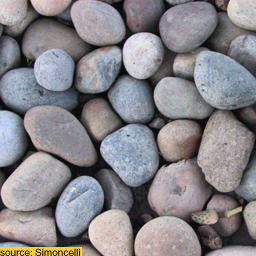

In [5]:
# Show Image
show_image(image_data, False)

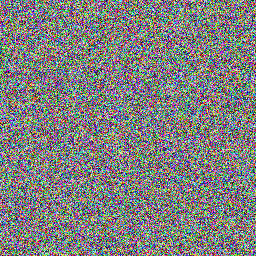

In [6]:
show_image(white_data, False)

In [7]:
# Load Model
model = Modified_VGG19(device=device)

In [8]:
# The first run model
model(image_data)
# Get feature maps
feature_maps = [ item.detach() for item in model.get_feature_maps() ]
# Clear grad data
model.zero_grad()

In [9]:
# Def feature maps -> gram matrices function
def feature_to_gram(feature_maps : list[torch.Tensor]) -> list[torch.Tensor]:
    feature_maps_flattened = [ torch.flatten(feature, start_dim=1) for feature in feature_maps ] 
    Gram_Matrices = [ torch.matmul(item, torch.transpose(item, 0, 1)) for item in feature_maps_flattened ]
    return Gram_Matrices

In [10]:
# Def Loss Function （总体loss）
def loss(feature_maps       : list[torch.Tensor], 
         train_feature_maps : list[torch.Tensor],
         weights            : torch.Tensor
        ) -> torch.Tensor:
    
    # Define each gram matrix loss （对某一层的一对gram matrix算loss）
    def each_loss(gram_matrix : torch.Tensor, train_gram_matrix : torch.Tensor, shape : tuple[int]) -> torch.Tensor:
        assert train_gram_matrix.requires_grad == True
        assert gram_matrix.requires_grad       == False
        assert gram_matrix.shape == train_gram_matrix.shape
        tmp = gram_matrix - train_gram_matrix
        res = torch.pow(torch.linalg.matrix_norm(tmp), 2) / (4 * shape[0] * shape[0] * shape[1] * shape[1])
        return res
        
        
    shapes = [ item.shape for item in feature_maps ]
    
    # 得到总体的gram matrix
    gram_matrices       = feature_to_gram(feature_maps)
    train_gram_matrices = feature_to_gram(train_feature_maps)
    
    # 初始化返回值
    ret_value = torch.tensor([0.], requires_grad=False).to(device)
    
    assert len(gram_matrices) == len(train_gram_matrices)
    assert len(gram_matrices) == len(weights)
    
    # 计算总loss
    for gram_matrix, train_gram_matrix, weight, shape in zip(gram_matrices, train_gram_matrices, weights, shapes):
        ret_value += weight * each_loss(gram_matrix=gram_matrix,
                                        train_gram_matrix=train_gram_matrix,
                                        shape=shape)
    return ret_value

In [11]:
# Define run
def train(model, feature_maps : list[torch.Tensor], image_data : torch.Tensor, optimizer, loops:int) -> torch.Tensor:
    weights = [ 0 for i in range(len(feature_maps)-35) ]
    weights = [1 for i in range(35)] + weights
    
    weights = torch.tensor(weights).to(device)
        
    for i in tqdm(range(loops)):
        def closure():
            optimizer.zero_grad()
            train_feature_maps = model(image_data)
            l = loss(feature_maps, train_feature_maps, weights=weights)
            l.backward()
            # print(l)
            return l
        
        optimizer.step(closure)
        
    return image_data

In [12]:
import torch.optim as optim
data = white_data.detach()
data.requires_grad_(True)
# 调用torch的LBFGS优化器
optimizer = optim.LBFGS([data], lr=1, max_iter=20)

print(len(feature_maps))
train(model, feature_maps, data, optimizer, 30)

35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:35<00:00,  1.17s/it]


tensor([[[0.3839, 0.3629, 0.0877,  ..., 0.5441, 0.4621, 0.6678],
         [0.3344, 0.4324, 0.3910,  ..., 0.3833, 0.4797, 0.4968],
         [0.2442, 0.3456, 0.2830,  ..., 0.5224, 0.4603, 0.4203],
         ...,
         [0.5596, 0.5821, 0.5450,  ..., 0.6712, 0.6594, 0.6625],
         [0.4145, 0.7552, 0.5286,  ..., 0.7190, 0.5685, 0.7433],
         [0.6417, 0.7820, 0.5100,  ..., 0.5262, 0.6391, 0.6196]],

        [[0.4374, 0.3797, 0.4865,  ..., 0.4471, 0.3903, 0.3112],
         [0.3840, 0.3020, 0.3024,  ..., 0.5429, 0.4931, 0.2328],
         [0.3594, 0.5346, 0.3851,  ..., 0.2656, 0.4515, 0.3310],
         ...,
         [0.5804, 0.5878, 0.6163,  ..., 0.5582, 0.5989, 0.6171],
         [0.8740, 0.4098, 0.6246,  ..., 0.5366, 0.7296, 0.4615],
         [0.4692, 0.6547, 0.7321,  ..., 0.5888, 0.6330, 0.4863]],

        [[0.4345, 0.4839, 0.5027,  ..., 0.3799, 0.4682, 0.4428],
         [0.3972, 0.4313, 0.3313,  ..., 0.3227, 0.2870, 0.5376],
         [0.6874, 0.3444, 0.5643,  ..., 0.6171, 0.2843, 0.

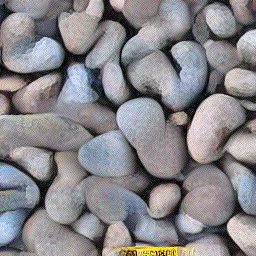

In [13]:
show_image(data, False)

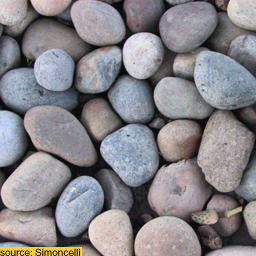

In [14]:
show_image(image_data, False)